In [2]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import cv2
import copy

In [2]:
img1_bgr = cv2.imread('image1.jpg')
Img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_bgr = cv2.imread('image2.jpg')
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(Img1)
pts = []
# pts = np.asarray(plt.ginput(4))  

print(f'Points = {pts}')

Points = []


In [3]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f'\n{self.x}, {self.y}'
    def __repr__(self):
        return f'\n{self.x}, {self.y}'
image1_points4 = [Point(523, 487), Point(935, 444), Point(555, 1099), Point(964, 1161)]
Img2Height, Img2Width, _ = img2.shape
image2_points4 = [Point(0, 0), Point(Img2Width, 0), Point(0, Img2Height), Point(Img2Width, Img2Height)]

In [4]:
def Xrow(Img1: Point, Img2: Point):
    return np.array([Img1.x, Img1.y, 1, 0, 0, 0, -Img1.x*Img2.x, -Img1.y*Img2.x])

def Yrow(Img1: Point, Img2: Point):
    return np.array([0, 0, 0, Img1.x, Img1.y, 1, -Img1.x*Img2.y, -Img1.y*Img2.y])

def matrixA(Img1_pts, Img2_pts):
    if not (len(Img1_pts) == len(Img2_pts)):
        raise ValueError("Incorrect Number of points!")
    A = None
    
    for i in range(len(Img1_pts)): 
        x = Xrow(Img1_pts[i], Img2_pts[i])
        y = Yrow(Img1_pts[i], Img2_pts[i])
        if A is None:
            A = np.array([x, y]) 
        else:
            A = np.vstack([A, x, y])
    return A

def calc_H(A, b):
    if all (len (row) == len (A) for row in A):
        H = np.linalg.solve(A,b)
    else:
        res = np.linalg.lstsq(A,b, rcond=-1)
        H = res[0]
    H = np.append(H,[1])
    H = np.reshape(H,(3, 3))
    return H

A = matrixA(image2_points4, image1_points4)
b = [coord for point in image1_points4 for coord in (point.x, point.y)]
H = calc_H(A, b)
H4 = copy.deepcopy(H)

print(f"A Matrix: {A}")
print(f"b Matrix: {b}")
print(f"H Matrix: {H}")

A Matrix: [[      0       0       1       0       0       0       0       0]
 [      0       0       0       0       0       1       0       0]
 [    450       0       1       0       0       0 -420750       0]
 [      0       0       0     450       0       1 -199800       0]
 [      0     446       1       0       0       0       0 -247530]
 [      0       0       0       0     446       1       0 -490154]
 [    450     446       1       0       0       0 -433800 -429944]
 [      0       0       0     450     446       1 -522450 -517806]]
b Matrix: [523, 487, 935, 444, 555, 1099, 964, 1161]
H Matrix: [[ 6.08075384e-01  9.39336911e-02  5.23000000e+02]
 [-2.41567530e-01  1.41612723e+00  4.87000000e+02]
 [-3.28855798e-04  3.99726346e-05  1.00000000e+00]]


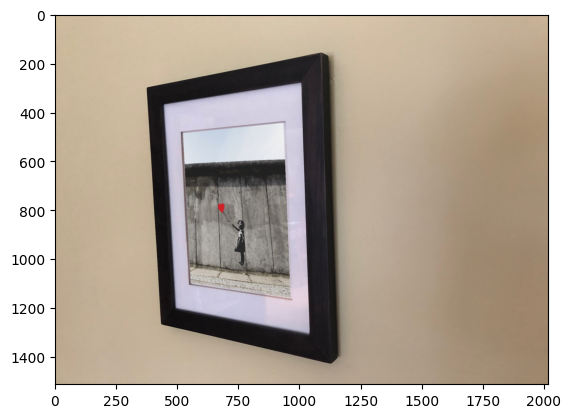

In [5]:
%matplotlib inline
scale = 3
finalImg = None
def Overlay(Img1, Img2, mask):
    img2Cpy = Img2.copy()
    img2Cpy[np.where(mask == 255)] = Img1[np.where(mask == 255)]
    return img2Cpy

finalImg = cv2.warpPerspective( src = img2, M = H, dsize = (Img2Width*scale, Img2Width*scale), borderMode=cv2.BORDER_TRANSPARENT)
mask = cv2.inRange(finalImg, 0, 0)
im_mask = cv2.bitwise_not(mask)

stitchedImgs = Overlay(finalImg, Img1, im_mask) 
plt.figure()
plt.imshow(stitchedImgs)

In [6]:
def mean(a, b):
    temp = int(float(a + b)/2)
    return temp

image1_points8 = [Point(523, 487), Point(935, 444), Point(555, 1099), Point(964, 1161),
                  Point(mean(523, 935), mean(487, 444)),
                  Point(mean(555, 964), mean(1099,1161)),
                  Point(mean(935,964), mean(444, 1161)),
                  Point(mean(523,555), mean(487, 1099))]

image2_points8 = [Point(0, 0), Point(Img2Width, 0), Point(0, Img2Height), Point(Img2Width, Img2Height),
                  Point(mean(0, Img2Width), mean(0, 0)),
                  Point(mean(0, Img2Width), mean(Img2Height, Img2Height)),
                  Point(mean(Img2Width, Img2Width), mean(0, Img2Height)),
                  Point(mean(0, 0), mean(0, Img2Height))]

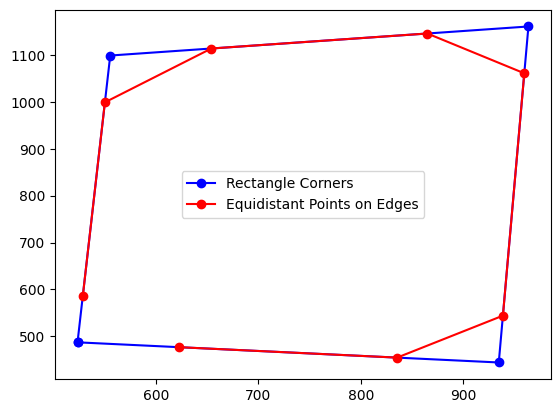

[
622.4597658435313, 476.6194904580781, 
835.5402341564687, 454.3805095419219, 
939.0413261454581, 543.9183050446015, 
959.9586738545419, 1061.0816949553985, 
865.129534832712, 1146.0123011237852, 
653.870465167288, 1113.9876988762148, 
549.7783748964991, 999.1364198955471, 
528.2216251035009, 586.8635801044529]


In [7]:
points = [(523, 487), (935, 444), (964, 1161), (555, 1099)]
# points = [(0, 0), (Img2Width, 0), (Img2Width, Img2Height), (0, Img2Height)]

points = [(float(x), float(y)) for x, y in points]

midpoints = []
for i in range(4):
    next_index = (i + 1) % 4
    x_mid = (points[i][0] + points[next_index][0]) / 2
    y_mid = (points[i][1] + points[next_index][1]) / 2
    midpoints.append((x_mid, y_mid))

def equidistant_points_on_edge(start_point, end_point, distance):
    direction_vector = np.array(end_point) - np.array(start_point)
    direction_vector /= np.linalg.norm(direction_vector) 
    equidistant_point1 = np.array(start_point) + direction_vector * distance
    equidistant_point2 = np.array(end_point) - direction_vector * distance
    return tuple(equidistant_point1), tuple(equidistant_point2)

equidistant_points_list = []
distance = 100.0 
for i in range(4):
    equidistant_point1, equidistant_point2 = equidistant_points_on_edge(points[i], points[(i + 1) % 4], distance)
    equidistant_points_list.extend([equidistant_point1, equidistant_point2])

x, y = zip(*points)
plt.plot(x + (x[0],), y + (y[0],), marker='o', linestyle='-', color='b', label='Rectangle Corners')
x, y = zip(*equidistant_points_list)
plt.plot(x, y, marker='o', linestyle='-', color='r', label='Equidistant Points on Edges')
plt.legend()
plt.show()
POINTS1 = [Point(x, y) for x, y in equidistant_points_list]
print(POINTS1)


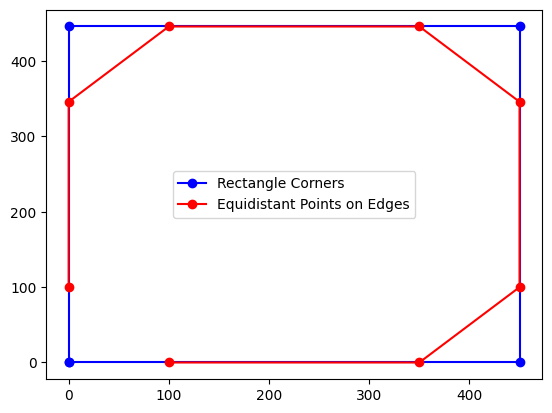

[
100.0, 0.0, 
350.0, 0.0, 
450.0, 100.0, 
450.0, 346.0, 
350.0, 446.0, 
100.0, 446.0, 
0.0, 346.0, 
0.0, 100.0]


In [8]:
# points = [(523, 487), (935, 444), (964, 1161), (555, 1099)]
points = [(0, 0), (Img2Width, 0), (Img2Width, Img2Height), (0, Img2Height)]

points = [(float(x), float(y)) for x, y in points]

midpoints = []
for i in range(4):
    next_index = (i + 1) % 4
    x_mid = (points[i][0] + points[next_index][0]) / 2
    y_mid = (points[i][1] + points[next_index][1]) / 2
    midpoints.append((x_mid, y_mid))

def equidistant_points_on_edge(start_point, end_point, distance):
    direction_vector = np.array(end_point) - np.array(start_point)
    direction_vector /= np.linalg.norm(direction_vector) 
    equidistant_point1 = np.array(start_point) + direction_vector * distance
    equidistant_point2 = np.array(end_point) - direction_vector * distance
    return tuple(equidistant_point1), tuple(equidistant_point2)

equidistant_points_list = []
distance = 100.0 
for i in range(4):
    equidistant_point1, equidistant_point2 = equidistant_points_on_edge(points[i], points[(i + 1) % 4], distance)
    equidistant_points_list.extend([equidistant_point1, equidistant_point2])

x, y = zip(*points)
plt.plot(x + (x[0],), y + (y[0],), marker='o', linestyle='-', color='b', label='Rectangle Corners')
x, y = zip(*equidistant_points_list)
plt.plot(x, y, marker='o', linestyle='-', color='r', label='Equidistant Points on Edges')
plt.legend()
plt.show()
POINTS2 = [Point(x, y) for x, y in equidistant_points_list]
print(POINTS2)

H matrix is [[ 4.61543278e-01 -3.50565898e-02  5.40648551e+02]
 [-3.29146814e-01  1.26924476e+00  4.80481378e+02]
 [-4.32537705e-04 -1.32397287e-04  1.00000000e+00]]


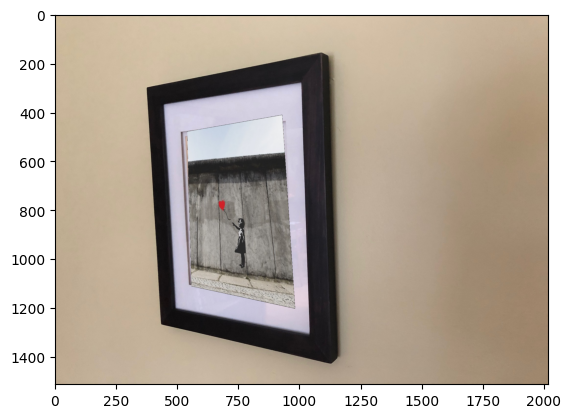

In [9]:
A = matrixA(POINTS2, POINTS1)
b = [coord for point in POINTS1 for coord in (point.x, point.y)]
H = calc_H(A, b)
print(f'H matrix is {H}')
H82 = copy.deepcopy(H)
finalImg = None
finalImg = cv2.warpPerspective(src = img2, M = H, dsize = (Img2Height*scale, Img2Width*scale))
mask = cv2.inRange(finalImg, 0, 0)
im_mask = cv2.bitwise_not(mask)

img2Cpy = Overlay(finalImg, Img1, im_mask) 
plt.figure()
plt.imshow(img2Cpy)

H matrix is [[ 6.38815517e-01  7.18338483e-02  5.27599851e+02]
 [-2.11613870e-01  1.40003238e+00  4.83271038e+02]
 [-2.89891117e-04  1.06827376e-05  1.00000000e+00]]


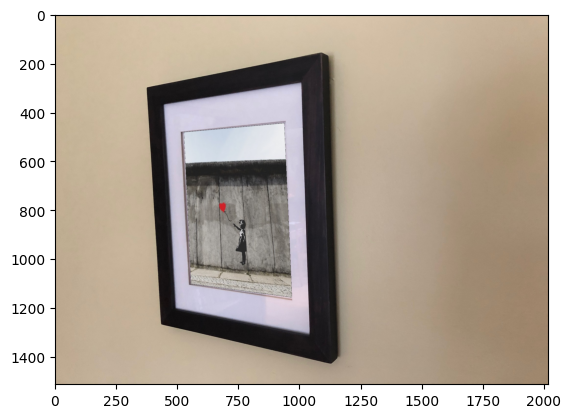

In [10]:
A = matrixA(image2_points8, image1_points8)
b = [coord for point in image1_points8 for coord in (point.x, point.y)]
H = calc_H(A, b)
print(f'H matrix is {H}')
H8 = copy.deepcopy(H)
finalImg = None
finalImg = cv2.warpPerspective(src = img2, M = H, dsize = (Img2Height*scale, Img2Width*scale))
mask = cv2.inRange(finalImg, 0, 0)
im_mask = cv2.bitwise_not(mask)

img2Cpy = Overlay(finalImg, Img1, im_mask) 
plt.figure()
plt.imshow(img2Cpy)

In [11]:
dest_pts = np.array([[point.x, point.y] for point in image1_points4])
src_pts = np.array([[point.x, point.y] for point in image2_points4])
h, status = cv2.findHomography(src_pts, dest_pts)
print(f'H with 4 points : \n{H4}\n\n\nH with 8 points (non-midpoints): \n{H82}\n\n\nH with 8 points (midpoints) : \n{H8}\n\n\nH calculated with cv2 : \n{h}')

H with 4 points : 
[[ 6.08075384e-01  9.39336911e-02  5.23000000e+02]
 [-2.41567530e-01  1.41612723e+00  4.87000000e+02]
 [-3.28855798e-04  3.99726346e-05  1.00000000e+00]]


H with 8 points (non-midpoints): 
[[ 4.61543278e-01 -3.50565898e-02  5.40648551e+02]
 [-3.29146814e-01  1.26924476e+00  4.80481378e+02]
 [-4.32537705e-04 -1.32397287e-04  1.00000000e+00]]


H with 8 points (midpoints) : 
[[ 6.38815517e-01  7.18338483e-02  5.27599851e+02]
 [-2.11613870e-01  1.40003238e+00  4.83271038e+02]
 [-2.89891117e-04  1.06827376e-05  1.00000000e+00]]


H calculated with cv2 : 
[[ 6.08075384e-01  9.39336911e-02  5.23000000e+02]
 [-2.41567530e-01  1.41612723e+00  4.87000000e+02]
 [-3.28855798e-04  3.99726346e-05  1.00000000e+00]]


#### THE H MATRIX
- I have considered the 4 corners of the image while calculating the H matrix with 4 points.
- For the section where we need to select 8 points, I first tried taking 2 points on each edge so that there are no 3 colinear points present. With this, the H matrix was quite different that the one calculated using just 4 points. 
    This is further seen in the overlayed image, as the second image is not overlayed properly on the first image.
- I also tried using the midpoints of the edges to calculate the H matrix and by using this method, the values of the H matrix were comparable to the values calculated using 4 points. 
    The output for this confirms this, as the second image is properly overlayed on top of the first image. 

In [12]:
img3_bgr = cv2.imread('image3.jpg')
img3 = cv2.cvtColor(img3_bgr, cv2.COLOR_BGR2RGB)
Img3Height, Img3Width, _ = img3.shape
image3_points4 = [Point(0, 0), Point(Img3Width, 0), Point(0, Img3Height), Point(Img3Width, Img3Height)]

A = matrixA(image3_points4, image1_points4)
b = [coord for point in image1_points4 for coord in (point.x, point.y)]
H = calc_H(A, b)

print(f"A Matrix: {A}")
print(f"b Matrix: {b}")
print(f"H Matrix: {H}")

A Matrix: [[       0        0        1        0        0        0        0        0]
 [       0        0        0        0        0        1        0        0]
 [    2300        0        1        0        0        0 -2150500        0]
 [       0        0        0     2300        0        1 -1021200        0]
 [       0     3000        1        0        0        0        0 -1665000]
 [       0        0        0        0     3000        1        0 -3297000]
 [    2300     3000        1        0        0        0 -2217200 -2892000]
 [       0        0        0     2300     3000        1 -2670300 -3483000]]
b Matrix: [523, 487, 935, 444, 555, 1099, 964, 1161]
H Matrix: [[ 1.18971271e-01  1.39648087e-02  5.23000000e+02]
 [-4.72632124e-02  2.10530916e-01  4.87000000e+02]
 [-6.43413518e-05  5.94259834e-06  1.00000000e+00]]


#### Own Image (PG-13):
The following output shows my own image overlayed on top of the first image.

Fun Fact: It is a digtal drawing created by me!!

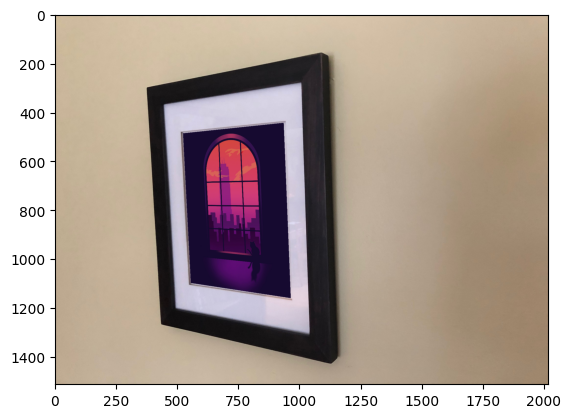

In [13]:
scale = 3
finalImg2 = None

finalImg2 = cv2.warpPerspective( src = img3, M = H, dsize = (Img3Width*scale, Img3Width*scale), borderMode=cv2.BORDER_TRANSPARENT)
mask2 = cv2.inRange(finalImg2, 0, 0)
im_mask2 = cv2.bitwise_not(mask2)

stitchedImgs = Overlay(finalImg2, Img1, im_mask2) 
plt.figure()
plt.imshow(stitchedImgs)

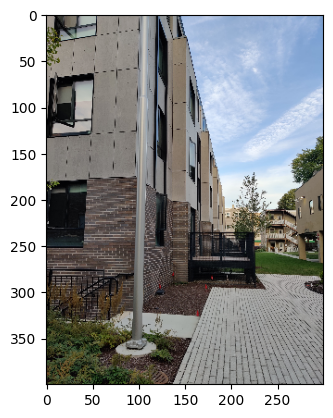

In [11]:
%matplotlib inline
folder = "imgs/"
fileType = ".jpg"

ImageFiles = ['img1', 'img2', 'img3', 'img4', 'img5']
images = {}

# Img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)

for file in ImageFiles:
    filename = folder + file + fileType
    images[file] = cv2.imread(filename)
    images[file] = cv2.cvtColor(images[file], cv2.COLOR_BGR2RGB)
    images[file] = cv2.resize(images[file], (0,0), fx=0.1, fy=0.1)
    # images[file] = image
    # plt.imshow(images[file])
    # # plt.title(file)
    # plt.axis('off')
    # plt.show()

plt.figure()
plt.imshow(images['img1'])
plt.show()
matplotlib.use('TkAgg')
# for file in fns:
#     plt.figure()
#     plt.imshow(imgs[file])
#     pts = np.asarray(plt.ginput(4)) 
#     print(pts)

# # plt.show()
# plt.close('all')

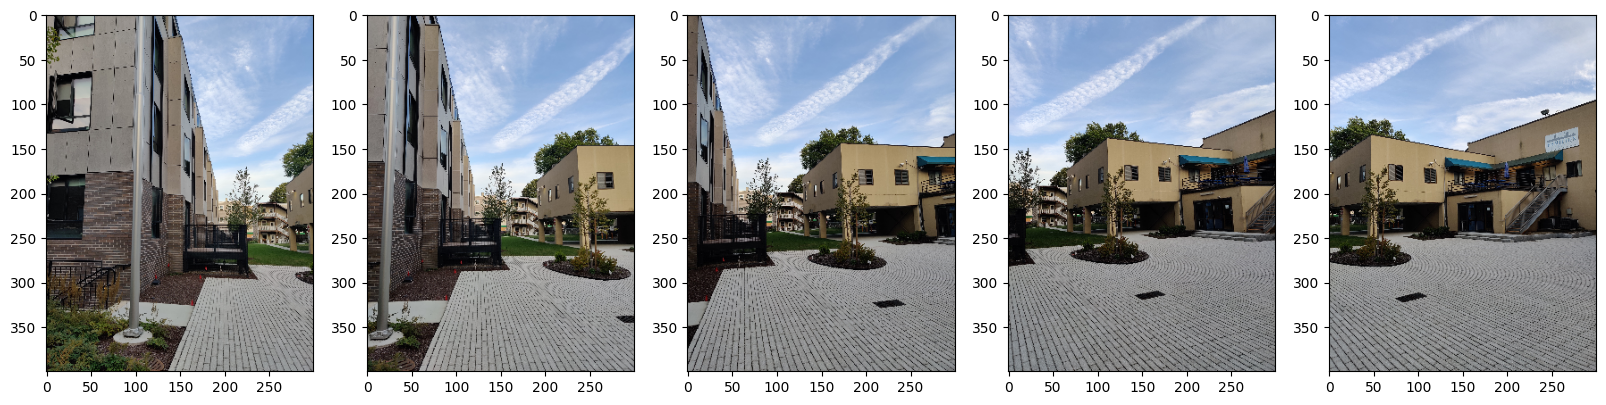

In [29]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
i=1
for image in ImageFiles:
    fig.add_subplot(1, 5, i)
    plt.imshow(images[image])
    i+=1

In [15]:
%matplotlib inline

common1_2 = { "img1": [Point(154, 67),Point(268, 190),Point(235, 293),Point(104,322)], "img2": [Point(82, 54),Point(188, 187),Point(158, 285),Point(24, 320)] }
common2_3 = { "img2": [Point(101, 105),Point(233, 146),Point(277, 339),Point(90,319)], "img3": [Point(36, 92),Point(169, 144),Point(206, 323),Point(23, 318)] }
common3_4 = { "img3": [Point(172, 144),Point(95, 280),Point(205, 323),Point(260,188)], "img4": [Point(110, 137),Point(28, 279),Point(141, 315),Point(196, 183)] }
common4_5 = { "img4": [Point(110, 137),Point(140, 315),Point(273, 250),Point(283,136)], "img5": [Point(46, 132),Point(75, 316),Point(203, 249),Point(214, 144)] }


In [16]:
class ImgClass:
    def __init__(self, image, points):
        self.image = image
        self.points = points
        
def movImg(Img: ImgClass, dx=0, dy=0):
    pts2 = []
    for point in Img.points:
        pts2.append(Point(point.x + dx, point.y + dy))
    cols2 = np.zeros((Img.image.shape[0], dx, Img.image.shape[2])) 
    newImg = np.hstack([cols2.astype("uint8"), Img.image])
    return ImgClass(newImg, pts2)

def stitchImg(Img1: ImgClass, Img2: ImgClass, left = False):
    H, dx = None, 0
    if left:
        dx = Img1.image.shape[1]
        Img2 = movImg(Img2, dx)
    if H is None:
        A = matrixA(Img1.points, Img2.points)
        b = [coord for point in Img2.points for coord in (point.x, point.y)]
        H = calc_H(A, b)
    print(f"H matrix is {H} ")
    _, Img1_w, _ = Img1.image.shape
    Img2_h, Img2_w, _ = Img2.image.shape
    transformedImg = cv2.warpPerspective(Img1.image, H, (Img1_w + Img2_w, Img2_h))
    stitchedImgs = blendImgs(Img2.image, transformedImg)
    return (stitchedImgs, dx)

def blendImgs(Img1, Img2):
    fg, bg = Img1.copy(), Img2.copy()
    fg_h,fg_w,_ = fg.shape
    bg_h,bg_w,_ = bg.shape
    dy = bg_h - fg_h
    dx = bg_w - fg_w
    alpha = 0.75
    fg = cv2.copyMakeBorder(fg, top=0, left=0, bottom=dy, right=dx, borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])   
    fg_mask = cv2.inRange(fg, 0, 0)
    bg_mask = cv2.inRange(bg, 0, 0)
    blend = cv2.addWeighted(fg, alpha, bg, 1-alpha, 0, bg.shape)
    BGnotFG = (bg_mask != 255) & (fg_mask == 255)
    FGnotBG = (fg_mask != 255) & (bg_mask == 255)
    blend[BGnotFG] = bg[BGnotFG]
    blend[FGnotBG] = fg[FGnotBG]
    return blend

def MovPts(pts, dx=0, dy=0):
    return [Point(point.x + dx, point.y + dy) for point in pts]

H matrix is [[ 1.55646326e+00 -3.72809427e-02  2.01171190e+02]
 [ 2.52723178e-01  1.16616823e+00 -5.50842894e+01]
 [ 9.83660395e-04 -5.85318949e-05  1.00000000e+00]] 


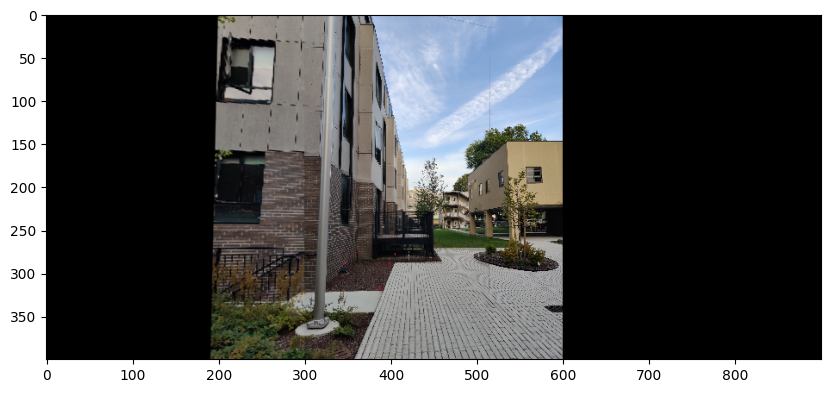

In [17]:
%matplotlib inline
combined121 = ImgClass(images["img1"], common1_2["img1"])
combined122 = ImgClass(images["img2"], common1_2["img2"])
stitched12, leftdx12 = stitchImg(combined121, combined122, left=True)
plt.figure(figsize=(10,10))
plt.imshow(stitched12)

H matrix is [[ 7.95588124e-01  1.02425748e-02  6.79396808e+01]
 [-1.64359868e-01  9.09179642e-01  1.94284717e+01]
 [-6.85730941e-04 -4.41767946e-05  1.00000000e+00]] 


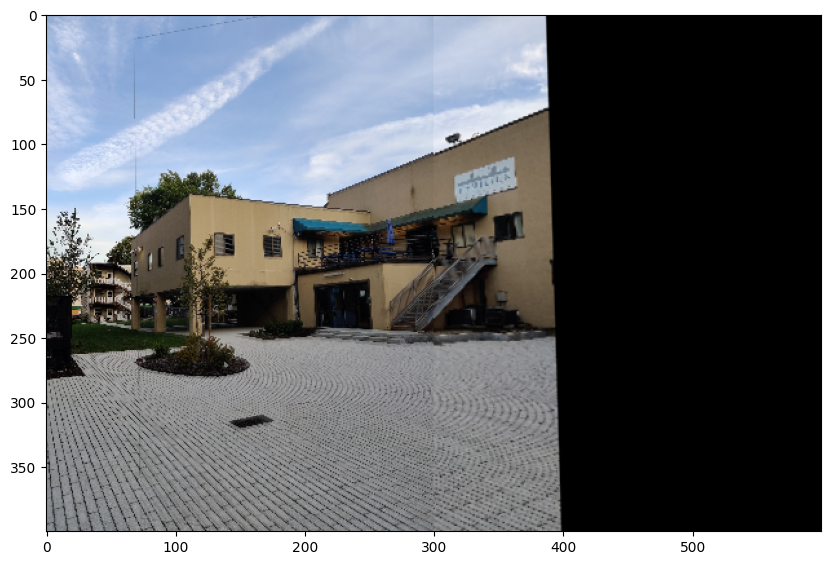

In [18]:
combined451 = ImgClass(images["img4"], common4_5["img4"])
combined452 = ImgClass(images["img5"], common4_5["img5"])
stitched45, leftdx45 = stitchImg(combined452 ,combined451)
plt.figure(figsize=(10,10))
plt.imshow(stitched45)

H matrix is [[ 2.90422529e+00  5.25140127e-02  2.52511457e+02]
 [ 2.83261153e-01  1.61815147e+00 -1.43663478e+02]
 [ 1.28051537e-03  6.10119428e-05  1.00000000e+00]] 


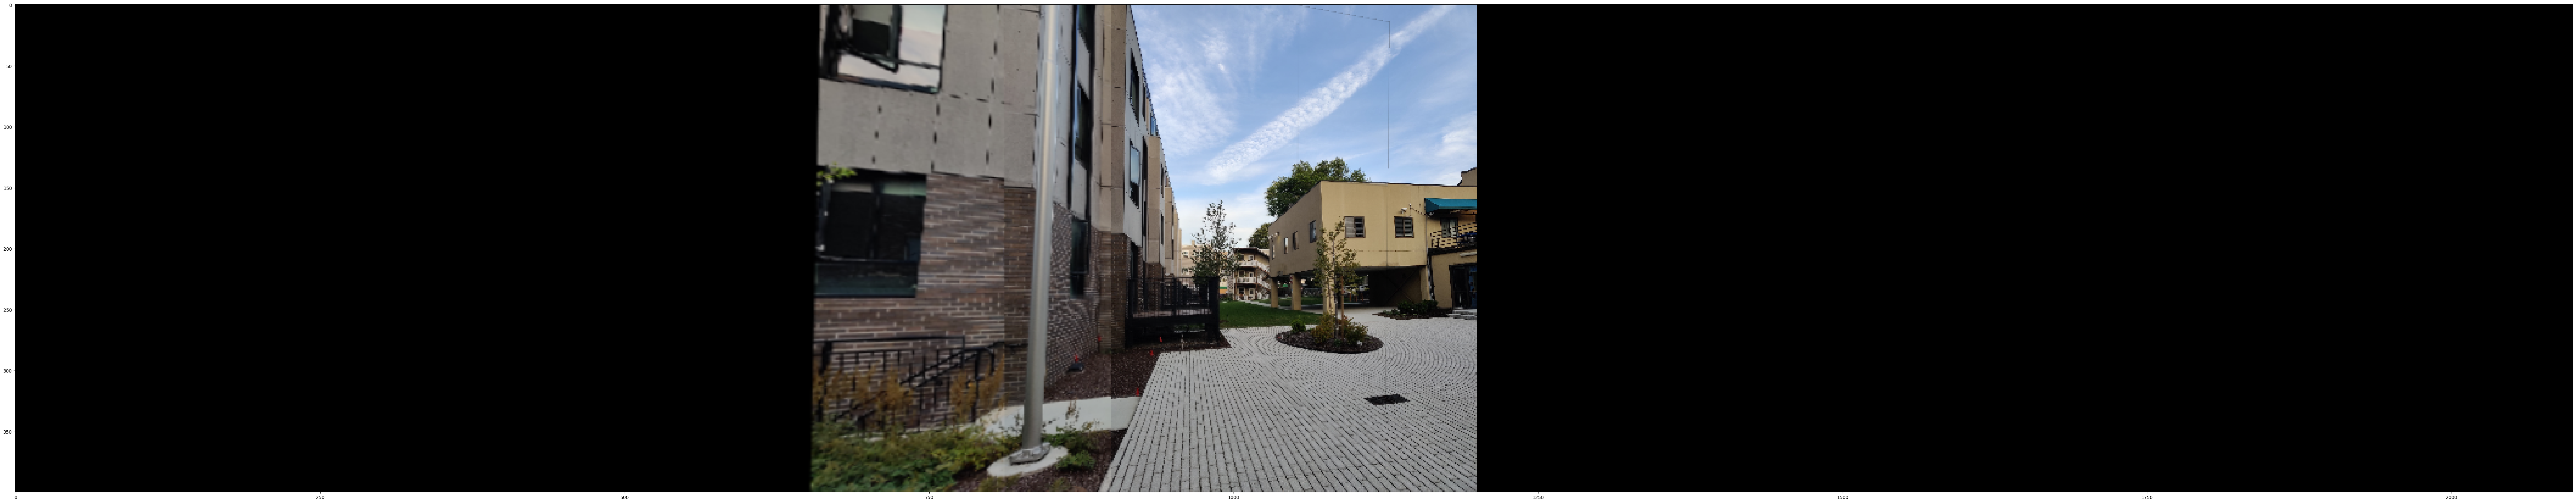

In [19]:
Stitched12Moved = ImgClass(stitched12, MovPts(common2_3["img2"], leftdx12))
combined231 = ImgClass(images["img3"], common2_3["img3"])
stitched123, leftdx123 = stitchImg(Stitched12Moved, combined231, left=True)
plt.figure(figsize=(100,100))
plt.imshow(stitched123)

H matrix is [[ 3.61424567e-01 -2.18069794e-01  9.73969626e+02]
 [-9.45853361e-02  8.44319988e-01  2.68916068e+01]
 [-4.86423228e-04 -2.09651152e-04  1.00000000e+00]] 


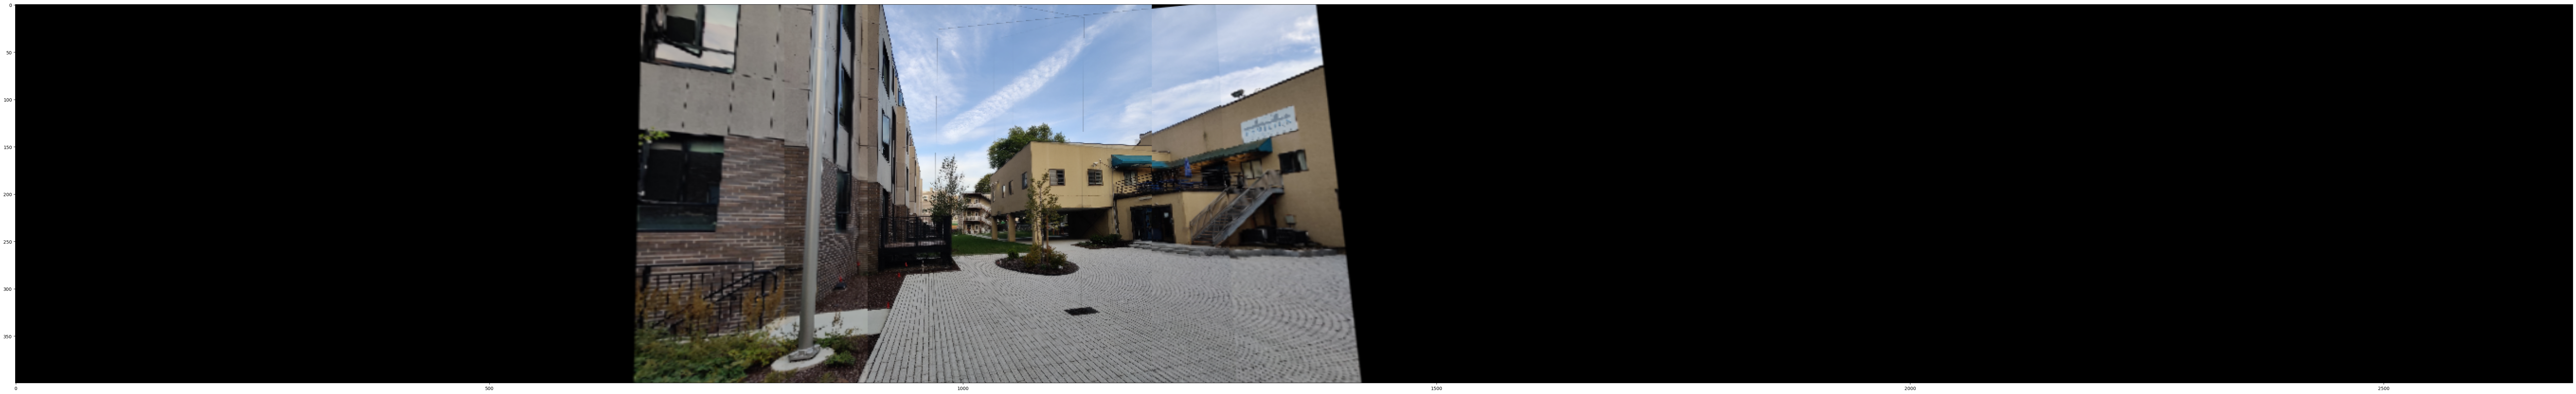

In [20]:
stitched123Moved = ImgClass(stitched123, MovPts(common3_4["img3"], leftdx123))
stitched45Moved = ImgClass(stitched45, MovPts(common3_4["img4"], leftdx45))
stitched12345, left12345dx2 = stitchImg(stitched45Moved, stitched123Moved)

plt.figure(figsize=(100,100))
plt.imshow(stitched12345[:,:,:])

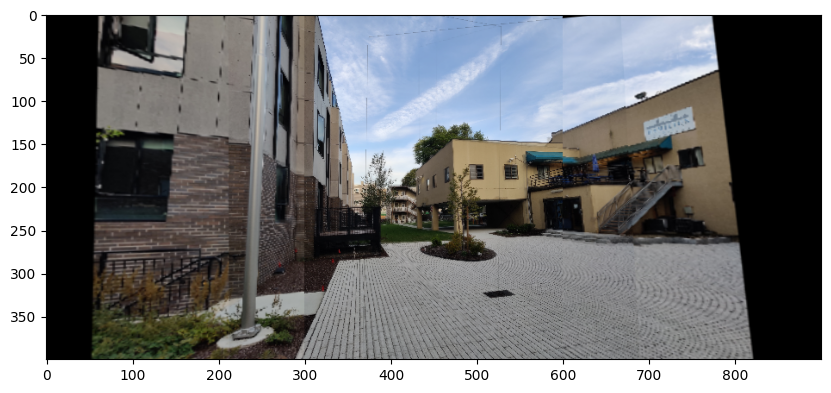

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(stitched12345[:,600:1500,:])

#### Blending!!

In this Assignment we have implemented a simple function which is part of the cv2 library called `addWeighted`. What is function does is that it basically will blend the images based on a fixed value (alpha). For example, if alpha is 0.5 or 50%, the blended portion of the image will have 50% opacity of both the images.

In the classic paper by Burt and Adelson, they have implemented a more sophisticated blending method wherein they blend the images with a gradient. Basically, the center of the overlapping image will have 50% of both the images. As we move to the right, the opacity of the right image will increase gradually reaching a 100% at the edge of the overlap. Similarly, if we move to the left of the center of the overlap, the opacity of the Left iamge will increase gradually upto 100% at the edge of the overlapping portion. In addition to this, they are implement a Gaussian pyramid strcture to calculate the blending at different scales in order to improve the blending result. They have also implemted a Gradient Domain blending, where the image is converted to a 2nd derivatives by differentiating, then blending the images and the reintegrating to obtain the final result.
Efros & Freeman created a method which cuts the overlapping sections to merge them. This is particularly helpful if there is a pattern that needs to be blended between images. As it can be seen in the images I have stitched in the output above, the ground is covered with Paver blocks which do not really match or blend properly. This method could potentially help solve this issue.